In [92]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import talib as ta

from data import BinanceDataHandlerBacktest
try:
    import Queue as queue
except ImportError:
    import queue

In [93]:
# Load OHLCV data using the backtest uploader 

events=queue.Queue()
symbols=['BTC/USDT']
start_date='2023-04-01 00:00:00'

Loader=BinanceDataHandlerBacktest(events,symbols,start_date)

data_set=Loader.data_history[symbols[0]]

df = pd.DataFrame(data_set, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

In [94]:
df.tail()

,open,high,low,close,volume
timestamp,,,,,
2023-04-01 01:47:15,28471.80,28471.80,28470.39,28470.39,2.32663
2023-04-01 01:47:16,28470.16,28470.16,28470.16,28470.16,0.01060
2023-04-01 01:47:17,28470.16,28470.16,28468.10,28468.10,0.04188
2023-04-01 01:47:18,28468.10,28468.11,28468.10,28468.10,1.31166
2023-04-01 01:47:19,28468.11,28468.11,28468.10,28468.10,0.19828


In [95]:
# Add technical indicators as features

df['sma20'] = df['close'].rolling(20).mean()
df['sma50'] = df['close'].rolling(50).mean()
df['rsi14'] = ta.RSI(df['close'], timeperiod=14)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Define buy/sell labels based on the strategy
df['buy_signal'] = np.where((df['sma20'] > df['sma50']) & (df['rsi14'] < 30) & (df['macd'] > df['macdsignal']), 1, 0)
df['sell_signal'] = np.where((df['sma20'] < df['sma50']) & (df['rsi14'] > 70) & (df['macd'] < df['macdsignal']), 1, 0)

In [96]:
# Clean data by droping empty rows
df=df.dropna()

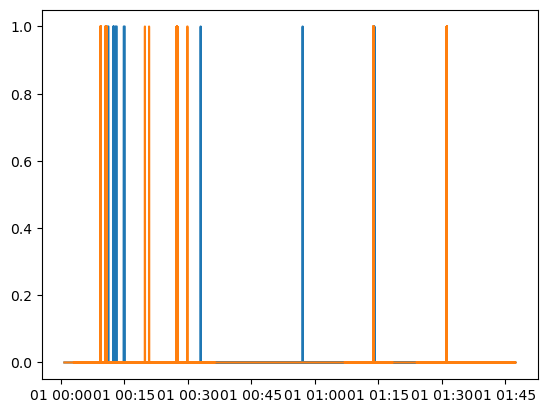

In [97]:
# Some visualisation
plt.plot(df['buy_signal'])
plt.plot(df['sell_signal'])
plt.show()

In [98]:
# Prepare data for machine learning
X = df[['open', 'high', 'low', 'close', 'volume', 'sma20', 'sma50', 'rsi14', 'macd', 'macdsignal', 'macdhist']].values
yb = df['buy_signal'].values
ys = df['buy_signal'].values


In [99]:
# Split data into training and testing sets
X_train, X_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2, random_state=42)
X_train, X_test, ys_train, ys_test = train_test_split(X, ys, test_size=0.2, random_state=42)

In [100]:

# Train Random Forest classifier
rfb = RandomForestClassifier(n_estimators=100, random_state=42)
rfb.fit(X_train, yb_train)

rfs = RandomForestClassifier(n_estimators=100, random_state=42)
rfs.fit(X_train, ys_train)

# Evaluate performance on testing set
yb_pred = rfb.predict(X_test)
accuracy = accuracy_score(yb_test, yb_pred)
print('Buy signal Model Accuracy:', accuracy)

ys_pred = rfs.predict(X_test)
accuracy = accuracy_score(ys_test, ys_pred)
print('Sell signal Model Accuracy:', accuracy)


Buy signal Model Accuracy: 0.9998999099189271
Sell signal Model Accuracy: 0.9998999099189271


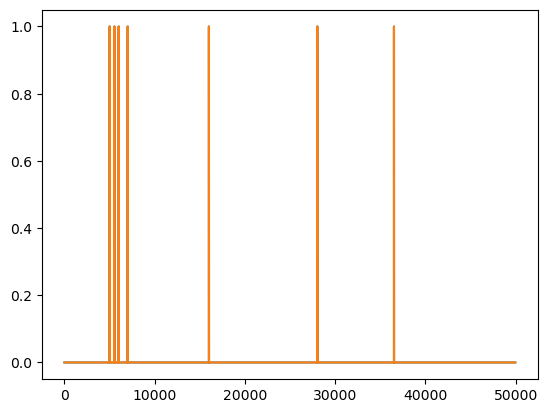

In [101]:
plt.plot(rfb.predict(X))
plt.plot(yb)

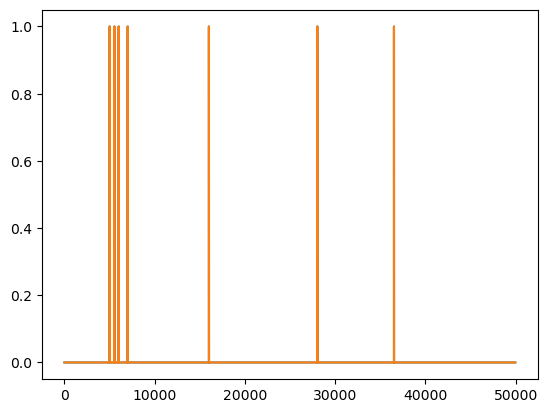

In [102]:
plt.plot(rfs.predict(X))
plt.plot(ys)